In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Preparing The Data

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
print(data_dir)

/root/.keras/datasets/flower_photos


/root/.keras/datasets/flower_photos/tulips/4573822295_5c5c6a5f6a.jpg


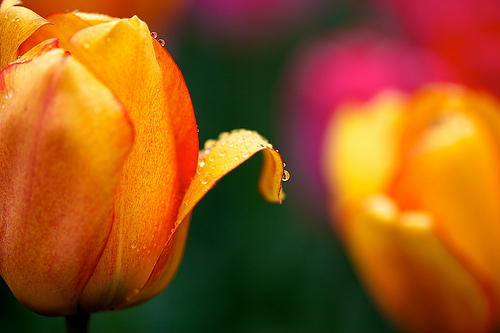

In [4]:
tulips = list(data_dir.glob('tulips/*'))
print(tulips[0])
PIL.Image.open(str(tulips[0]))

In [5]:
#Get a count of all the images in our training data
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


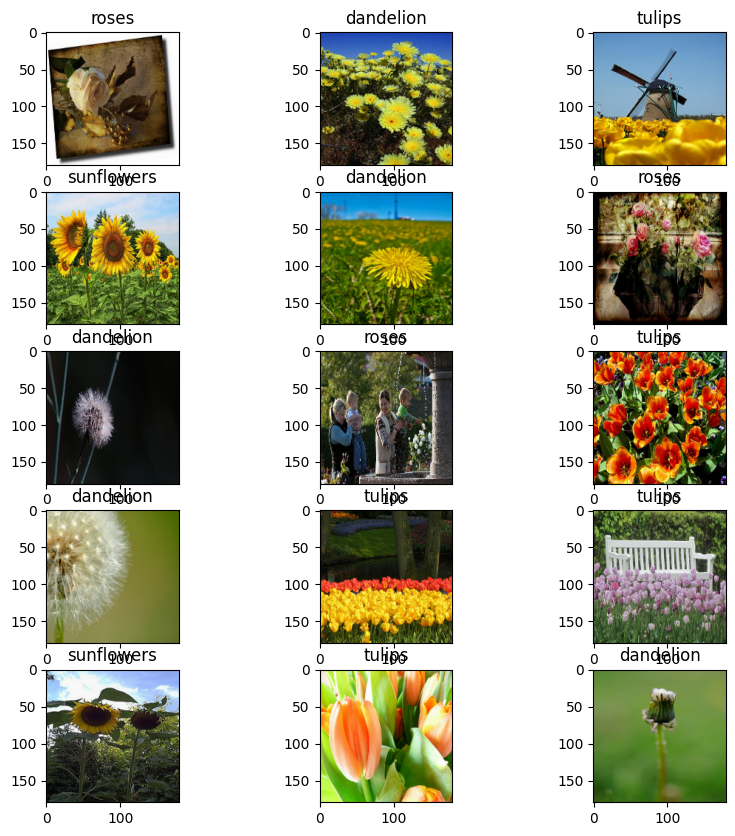

In [9]:
#Show some images for our traing data
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])


# Training The Model


In [10]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 10)               5130      
 pper)                                                           
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
____________________________________

In [12]:
resnet_model.compile(optimizer=Adam(lr=0.5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [13]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 19s 120ms/step - loss: 0.6851 - accuracy: 0.7837 - val_loss: 0.4157 - val_accuracy: 0.8556
Epoch 2/10
92/92 [==============================] - 10s 97ms/step - loss: 0.2975 - accuracy: 0.8944 - val_loss: 0.4215 - val_accuracy: 0.8501
Epoch 3/10
92/92 [==============================] - 9s 98ms/step - loss: 0.1841 - accuracy: 0.9363 - val_loss: 0.5457 - val_accuracy: 0.8324
Epoch 4/10
92/92 [==============================] - 9s 99ms/step - loss: 0.0992 - accuracy: 0.9683 - val_loss: 0.4834 - val_accuracy: 0.8624
Epoch 5/10
92/92 [==============================] - 9s 91ms/step - loss: 0.0800 - accuracy: 0.9721 - val_loss: 0.4729 - val_accuracy: 0.8624
Epoch 6/10
92/92 [==============================] - 10s 100ms/step - loss: 0.0831 - accuracy: 0.9697 - val_loss: 0.4438 - val_accuracy: 0.8787
Epoch 7/10
92/92 [==============================] - 10s 100ms/step - loss: 0.0533 - accuracy: 0.9806 - val_loss: 0.4781 - val_accuracy: 0.8828
Epoch 

# Evaluating The Model

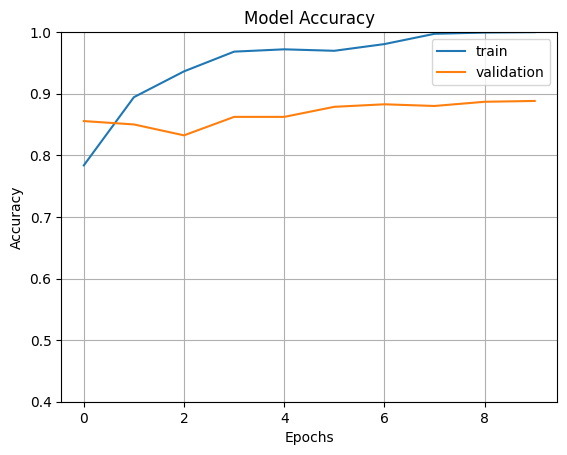

In [14]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

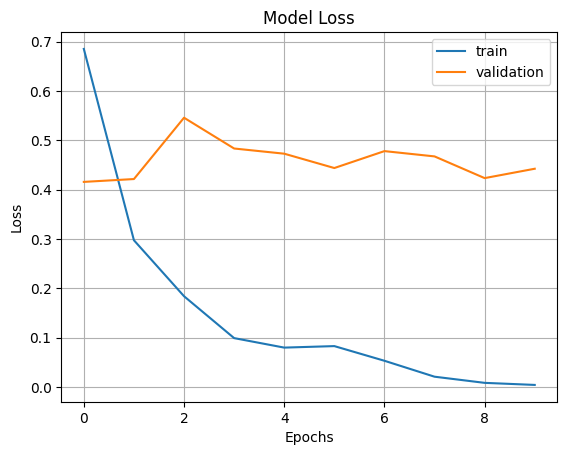

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [16]:
import cv2
image=cv2.imread(str(tulips[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)


(1, 180, 180, 3)


In [17]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 2s 2s/step
[[4.0593937e-07 8.0961904e-09 5.3606873e-06 1.4523693e-10 9.9999428e-01
  2.5748267e-14 9.2099557e-12 1.8471312e-12 5.2942420e-12 3.5535707e-13]]


In [18]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is tulips
